# CREDIT CARD FRAUD DETECTION

> Credit card fraud is on the increase as technology and global super highways develop.The cost to both businesses and consumers from this type of fraud costs billions of dollars every year. Fraudsters are continually finding new ways to commit their illegal activities. As a result, it has become essential for financial institutions and businesses to develop advanced fraud detection techniques to counter the threat of fraudulent credit card transactions and identity theft and keep losses to a minimum.

In `Credit Card Anomaly Detection` we know what the true positive looks like. How? Customers tell us. So we can use a supervised learning approach because the true class is self revealing

***Main Issues***
1. Severe class imbalance
2. Severe class overlap
3. Concept drift
4. Uncertainty around the data model

***Data source :*** https://www.kaggle.com/mlg-ulb/creditcardfraud

***Metrics: Recall, F1 Score***

In [1]:
# python libraries
import pickle
import time

# necessary libraries
import pandas as pd
from pandas.plotting import parallel_coordinates
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pandas_profiling

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# anomaly detection
from sklearn.ensemble import IsolationForest

# metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer

# cross validation
from sklearn.model_selection import cross_val_predict, cross_val_score

# hyperparameter
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# imbalance learning
from imblearn.over_sampling import SMOTE

# sklearn base
from sklearn.base import BaseEstimator, TransformerMixin
plt.style.use('seaborn')

In [2]:
# read the data
def load_data(PATH):
    return pd.read_csv(PATH)

credit = load_data('data/creditcard.csv')
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

There are no missing values in the data, we can see that the data is consuming a lot of memory, let's reduce the memory usage.

In [3]:
credit.iloc[:, :30] = credit.astype(np.float32)
credit.Class = credit.Class.astype(np.int8)
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

Since we are performing anomaly detection, we need to map our output to 1 and -1

1: Negative Class

-1: Positive Class
    
>The positive class is what we are concerned about and in this case, it is detecting if a transaction is fraudulent or not.

**Note:** The positive and negative class does not depend on the sign

In [4]:
credit.Class = credit.Class.map({0: 1, 1: -1})

It's always a good idea to divide our data into train and test set before we start analyzing the data. 

In [31]:
# divide the data to train and test set

train_set, test_set = train_test_split(credit, test_size=0.2, stratify=credit.Class)
print('train_set.shape: {}'.format(train_set.shape))
print('test_set.shape: {}'.format(test_set.shape))

train_set.shape: (182276, 31)
test_set.shape: (45569, 31)


In [6]:
credit = train_set.copy()
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
85691,60889.0,-0.514444,0.868809,0.870502,0.265611,-0.752100,-0.993845,0.629478,0.185626,-0.673267,...,0.235727,0.442191,0.233287,0.750847,-0.292883,0.248333,-0.128652,-0.015390,97.970001,1
271091,164406.0,2.174406,-0.606780,-2.150332,-0.973309,0.127966,-1.309548,0.283034,-0.570230,-1.058702,...,0.329453,0.829871,-0.046923,0.809306,0.390095,-0.030739,-0.083844,-0.059759,68.449997,1
111142,72111.0,-0.219345,1.284560,-0.261268,0.741158,0.410189,-0.218812,0.443980,0.487330,-0.877995,...,0.229513,0.734073,0.049985,-0.303559,-0.759477,-0.379191,0.324194,0.150707,3.590000,1
168673,119333.0,1.966705,0.528859,-2.867912,2.570742,3.411737,3.663854,0.211271,0.707393,-1.679046,...,0.092671,0.127701,0.091220,0.682237,0.315138,0.094877,-0.062526,-0.069647,9.460000,1
207347,136632.0,-1.888580,-0.956276,1.228546,-0.212396,-0.580579,0.442047,1.610099,0.149488,-0.193862,...,0.064435,-0.671610,0.878412,-0.513247,0.581718,-0.448466,0.131606,0.165159,455.739990,1


In [7]:
# profile the data, the result is saved in the file "ProfileReport.html", if you want an extensive report, set minimal=False
#prof = pandas_profiling.ProfileReport(credit, minimal=True)
#prof.to_file(output_file='ProfileReport.html')

In [8]:
credit.Class.value_counts(normalize=True)

 1    0.998271
-1    0.001729
Name: Class, dtype: float64

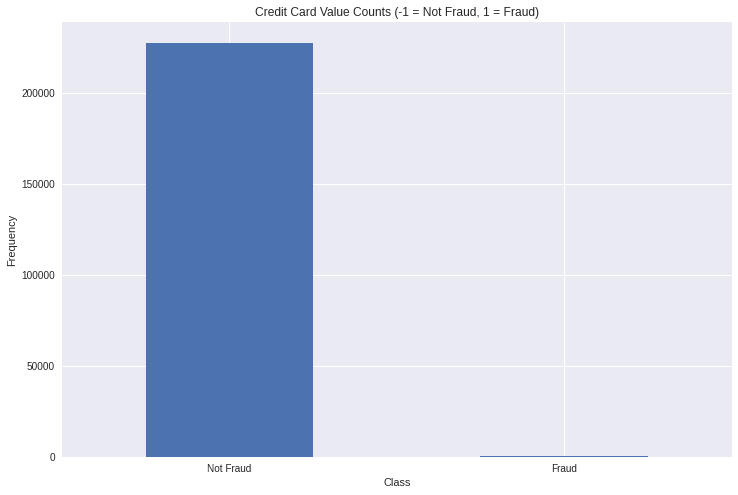

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
credit.Class.value_counts().plot.bar(rot=0)
plt.title('Credit Card Value Counts (-1 = Not Fraud, 1 = Fraud)')
plt.xticks(range(2), ['Not Fraud', 'Fraud'])
plt.ylabel('Frequency')
plt.xlabel('Class');
plt.show()

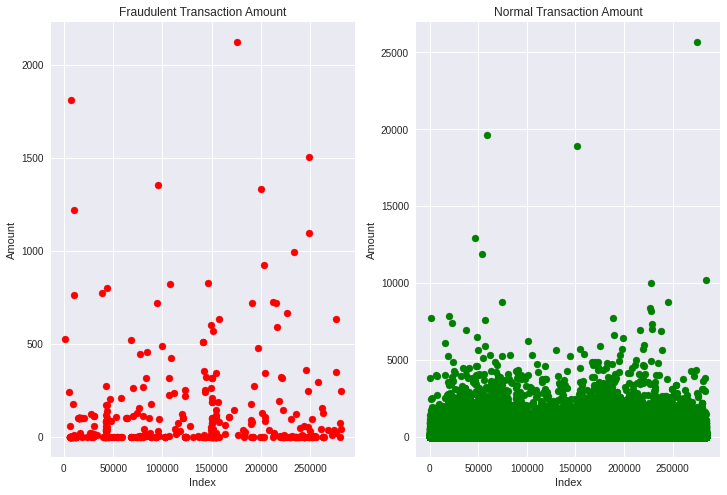

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
fraud = credit.Class == -1
normal = credit.Class != -1

ax[0].scatter(credit[fraud].index, credit[fraud].Amount, c='r')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Amount')
ax[0].set_title('Fraudulent Transaction Amount')
ax[1].scatter(credit[normal].index, credit[normal].Amount, c='g')
ax[1].set_xlabel('Index')
ax[1].set_ylabel('Amount')
ax[1].set_title('Normal Transaction Amount')
plt.show()

#### Points to Consider

- We can see from the report that our features are normally distributed. This is attributed to the fact that our feature labels are Principal components of the original datasets i.e our data has been scaled.
- There are 1825 Transactions where amounts = 0 which accounts for 0.6% of the entire datasets, we would want to look at that
- As expected, there is a huge class imbalance, Fraudulent Transactioms are less than 1% in the data set
- Fraudulent transactions typically have low `Amount`

In [11]:
zero_amount = credit[credit.Amount==0]
non_zero_amount = credit[credit.Amount!=0]

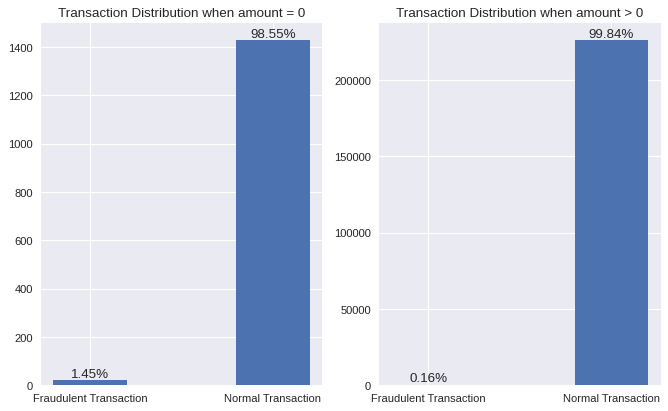

In [12]:
df1 = zero_amount.groupby('Class').size().reset_index(name='counts')
df2 = non_zero_amount.groupby('Class').size().reset_index(name='counts')
df1_sum = df1.counts.sum()
df2_sum = df2.counts.sum()

fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=80)
axes[0].bar(df1['Class'], df1['counts'])
for i, val in zip([-1, 1], df1.counts.values):
    axes[0].text(i, val, ('{:.2f}%'.format(val / df1_sum * 100)), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight': 500, 'size':12})

axes[1].bar(df2['Class'], df2['counts'])
for i, val in zip([-1, 1], df2.counts.values):
    axes[1].text(i, val, ('{:.2f}%'.format(val / df2_sum * 100)), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight': 500, 'size':12})
plt.sca(axes[0])
plt.xticks([-1, 1], ['Fraudulent Transaction', 'Normal Transaction'])
plt.sca(axes[1])
plt.xticks([-1, 1], ['Fraudulent Transaction', 'Normal Transaction'])
axes[0].set_title('Transaction Distribution when amount = 0')
axes[1].set_title('Transaction Distribution when amount > 0')
plt.show()

We can see that fraudulent transactions are more frequent in transactions with zero amount

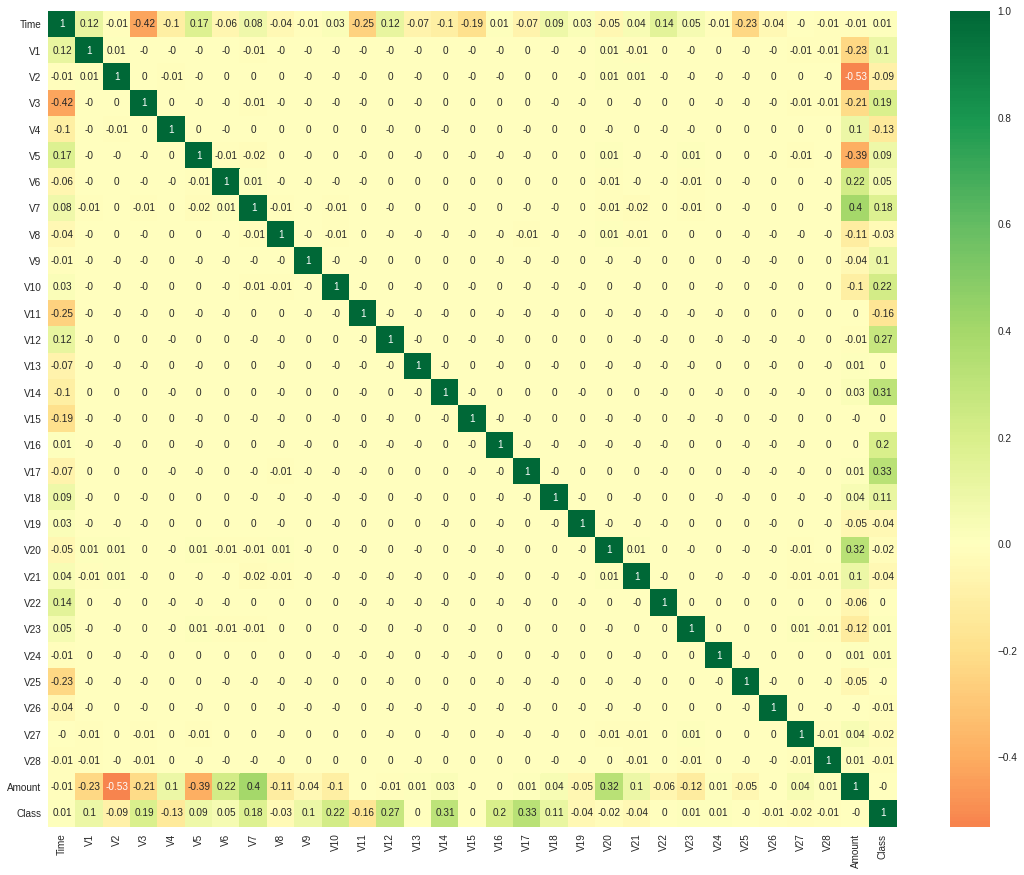

In [13]:
f = plt.figure(figsize=(19, 15))
sns.heatmap(round(credit.corr(), 2), xticklabels=credit.corr().columns, yticklabels=credit.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.show()

We plot a correlation map and we can see that `Class` is positively correlated with V17 and V14. It's is also correlated with V12, V10 and V16 but they are weak correlations

In [14]:
#columns = ['V17', 'V14', 'V12', 'V10', 'V16', 'Class']
#sample_data = credit.sample(frac=.3)
#parallel_coordinates(sample_data[columns], 'Class')

We can see a lot of overlaps in the feature, `V10` seems to do a good job in separating the two classes

In [15]:
def evaluate_model(true, pred, scores=None, show_plot=True, model_name=""):
    """
    Evaluate the performance of a model
    
    params:
    ----------------------------------
        true: True Labels
        pred: Predicted Labels
        score: Decision Function Scores
        show_plot: Display The Plot(default=True)
        model_name: Model Name
    """
    
    if show_plot and scores is not None:
        # set up figure structure
        fig, ax = plt.subplots(1, 3, figsize=(10, 3))
        
        # plot precision_recall_curve
        precisions, recalls, thresholds = precision_recall_curve(true, scores, pos_label=-1)
        ax[0].plot(thresholds, precisions[:-1], 'b', label='Precision')
        ax[0].plot(thresholds, recalls[:-1], 'g', label='Recall')
        ax[0].set_title('Precision and Recall Curve')
        ax[0].set_xlabel('Threshold')
        ax[0].legend(loc='best')
        
        # plot roc_curve
        fpr, tpr, thresholds = roc_curve(true, scores, pos_label=-1)
        ax[1].plot(fpr, tpr, 'b', lw=2)
        ax[1].plot([0, 1], [0, 1], 'k--')
        ax[1].set_xlabel('FPR')
        ax[1].set_ylabel('TPR')
        ax[1].set_title('ROC Curve')
        
        # plot confusion matrix
        c_m = confusion_matrix(true, pred)
        sns.heatmap(data=c_m, annot=True, ax=ax[2])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        labels = ['Anomaly', 'Normal']
        ax[2].set_xticklabels(labels)
        ax[2].set_yticklabels(labels)
        ax[2].set_title('Confusion Matrix')
        
        plt.show()
        
    print(f'Model Name: {model_name}')
    print(f'Precision Score: {precision_score(true, pred, pos_label=-1)}')
    print(f'Recall Score: {recall_score(true, pred, pos_label=-1)}')
    print(f'F1 Score: {f1_score(true, pred, pos_label=-1)}')
    print(f'ROC_AUC Score: {roc_auc_score(true, pred)}')
    print(f'\t\t\tClassification Report')
    print(classification_report(true, pred, target_names=['Anomaly', 'Normal']))

In [16]:
X = credit.drop('Class', axis=1)
y = credit.Class

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(182276, 30)
(45569, 30)
(182276,)
(45569,)


### Imbalanced Learning

In [18]:
class ClassifierSearchCV(BaseEstimator, TransformerMixin):
    
    def __init__(self, clf_params, cv=10, scoring='accuracy', n_jobs=1):
        self.clf_params = clf_params
        self.cv = cv
        self.scoring = scoring
        self.n_jobs = n_jobs
        
    def fit(self, X, y=None):
        return self
    
    def fitCV(self, X, y=None):
        self.X = X
        self.y = y
        self.model_scores = {}

        for _, clf in self.clf_params.items():
            clf.fit(self.X, self.y)
            self.model_scores[clf] = cross_val_score(clf, self.X, self.y, cv=self.cv, n_jobs=self.n_jobs, scoring=self.scoring).mean()
            
        self.best_classifier = None
        best_score = 0.0
        for clf, score in self.model_scores.items():
            if score > best_score:
                self.best_classifier = clf
                best_score = score
            
    def show_plot(self):

        for model_name, clf in self.clf_params.items():
            pred = None
            scores = None
            
            if 'decision_function' in dir(clf):
                scores = clf.decision_function(self.X)
                pred = cross_val_predict(clf, self.X, self.y, cv=self.cv, n_jobs=-1)
                
            elif 'predict_proba' in dir(clf):
                scores = cross_val_predict(clf, self.X, self.y, cv=self.cv, n_jobs=-1, method='predict_proba')[:, 0]
                pred = cross_val_predict(clf, self.X, self.y, cv=self.cv, n_jobs=-1)
                
            evaluate_model(self.y, pred, scores, show_plot=True, model_name=model_name)

In [19]:
clf_params = {
    'Forest': RandomForestClassifier(),
    'NB': GaussianNB()
}

#### SMOTE

In [20]:
smote_X_train, smote_y_train = SMOTE().fit_resample(X_train, y_train)
clf_search = ClassifierSearchCV(clf_params=clf_params, cv=3, n_jobs=-1, scoring='f1_micro')
clf_search.fitCV(smote_X_train, smote_y_train)
clf_search.best_classifier

RandomForestClassifier()

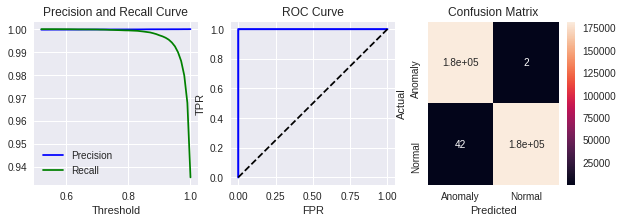

Model Name: Forest
Precision Score: 0.9997692320371866
Recall Score: 0.9999890086337182
F1 Score: 0.9998791082585543
ROC_AUC Score: 0.9998790949709003
			Classification Report
              precision    recall  f1-score   support

     Anomaly       1.00      1.00      1.00    181961
      Normal       1.00      1.00      1.00    181961

    accuracy                           1.00    363922
   macro avg       1.00      1.00      1.00    363922
weighted avg       1.00      1.00      1.00    363922



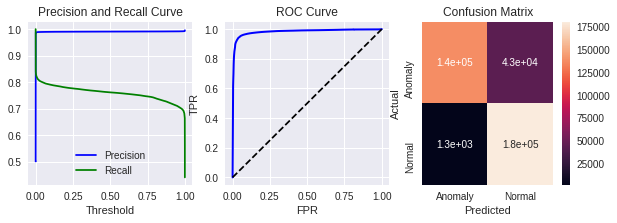

Model Name: NB
Precision Score: 0.9907223279302995
Recall Score: 0.7611576106967977
F1 Score: 0.8608989958322844
ROC_AUC Score: 0.8770148548315299
			Classification Report
              precision    recall  f1-score   support

     Anomaly       0.99      0.76      0.86    181961
      Normal       0.81      0.99      0.89    181961

    accuracy                           0.88    363922
   macro avg       0.90      0.88      0.88    363922
weighted avg       0.90      0.88      0.88    363922



In [21]:
clf_search.show_plot()

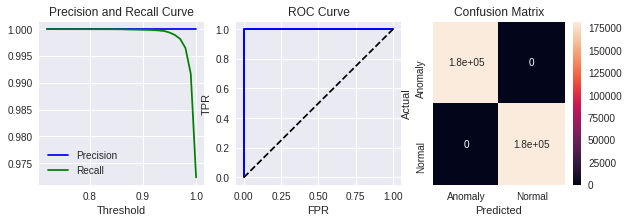

Model Name: Random Forest Classifier
Precision Score: 1.0
Recall Score: 1.0
F1 Score: 1.0
ROC_AUC Score: 1.0
			Classification Report
              precision    recall  f1-score   support

     Anomaly       1.00      1.00      1.00    181961
      Normal       1.00      1.00      1.00    181961

    accuracy                           1.00    363922
   macro avg       1.00      1.00      1.00    363922
weighted avg       1.00      1.00      1.00    363922



In [23]:
model = RandomForestClassifier(n_estimators=100,n_jobs=-1)
model.fit(smote_X_train, smote_y_train)
evaluate_model(model.predict(smote_X_train), smote_y_train, model.predict_proba(smote_X_train)[:, 0], True, 'Random Forest Classifier')

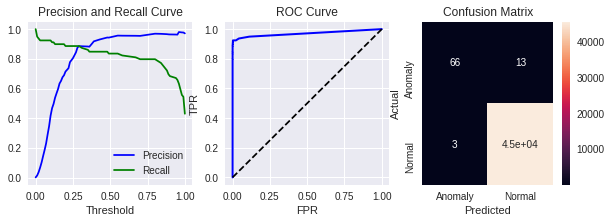

Model Name: Random Forest Classifier
Precision Score: 0.9565217391304348
Recall Score: 0.8354430379746836
F1 Score: 0.8918918918918919
ROC_AUC Score: 0.9176885447072802
			Classification Report
              precision    recall  f1-score   support

     Anomaly       0.96      0.84      0.89        79
      Normal       1.00      1.00      1.00     45490

    accuracy                           1.00     45569
   macro avg       0.98      0.92      0.95     45569
weighted avg       1.00      1.00      1.00     45569



In [24]:
predictions = model.predict(X_test)
scores = model.predict_proba(X_test)[:, 0]
evaluate_model(y_test, predictions, scores, show_plot=True, model_name='Random Forest Classifier')

In [25]:
def label_format(x, pos):
    return '{:.2f}%'.format(x)

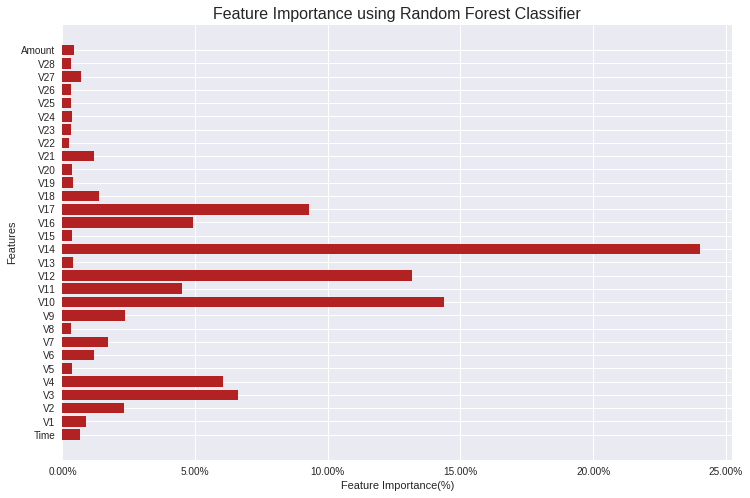

In [26]:
columns = smote_X_train.columns
feat_imp = model.feature_importances_ * 100

fig, ax = plt.subplots(figsize=(12, 8))
plt.barh(columns, feat_imp, color='firebrick')
ax.xaxis.set_major_formatter(label_format)
ax.set_xlabel('Feature Importance(%)')
ax.set_ylabel('Features')
ax.set_title('Feature Importance using Random Forest Classifier', fontsize=16)
plt.show()

In [27]:
cutoff = .05
selected_features = []
columns = smote_X_train.columns
feat_imp = model.feature_importances_

for c, f in zip(columns, feat_imp):
    if f > cutoff:
        selected_features.append(c)
        
selected_features

['V3', 'V4', 'V10', 'V12', 'V14', 'V17']

In [28]:
features = smote_X_train[selected_features]
labels = smote_y_train
features.head()

,V3,V4,V10,V12,V14,V17
0,-3.164249,-0.323270,0.780809,-0.152976,0.894981,0.385455
1,-0.472658,0.410333,1.106862,0.902102,-0.275392,-0.761491
2,-1.928759,-0.889810,-1.212038,-0.848160,1.381957,-0.336763
3,0.865333,-0.766871,-1.099639,0.386063,0.044349,0.180880
4,0.773241,1.264985,0.030784,0.724262,0.361330,-0.184211


### Testing and Evaluation

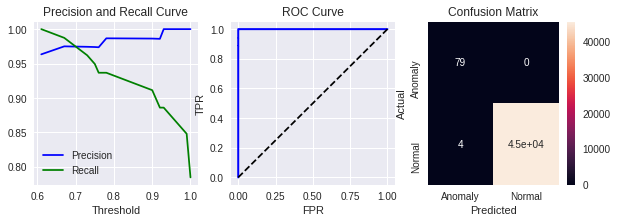

Model Name: Random Forest Classifier
Precision Score: 0.9518072289156626
Recall Score: 1.0
F1 Score: 0.9753086419753086
ROC_AUC Score: 0.9999560342932512
			Classification Report
              precision    recall  f1-score   support

     Anomaly       0.95      1.00      0.98        79
      Normal       1.00      1.00      1.00     45490

    accuracy                           1.00     45569
   macro avg       0.98      1.00      0.99     45569
weighted avg       1.00      1.00      1.00     45569



In [35]:
model.fit(features, labels) 
test_X = test_set.drop('Class', axis=1)[selected_features]
test_y = test_set.Class

pred_prob = model.predict_proba(test_X)[:, 0]
predictions = model.predict(test_X)
evaluate_model(test_y, predictions, pred_prob, show_plot=True, model_name='Random Forest Classifier')

In [36]:
pickle.dump(model, open('model/forest.pkl', 'wb'))

In [39]:
test_set[test_set.Class == -1][selected_features].head()

,V3,V4,V10,V12,V14,V17
18472,-2.971679,4.360089,-2.335933,-2.591950,-7.311580,6.509272
213116,-3.707414,4.544772,-4.250717,-4.563675,-6.964972,-6.419539
68067,0.901067,0.847753,-0.150129,-0.795988,0.578869,-0.119204
192529,-6.036770,3.552454,-5.569142,-5.896936,-11.221805,-1.588336
93424,-0.782432,4.083046,-3.162136,-4.635127,-6.435871,-3.654258
